<a href="https://colab.research.google.com/github/lewiskyron/genetic_algorithm-TSP-problem-/blob/main/Genetic_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generation: 1
Best distance: 39500.307


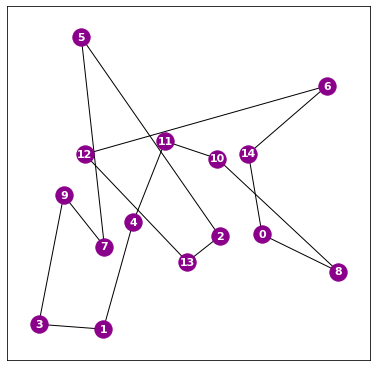

Generation: 223
Best distance: 26728.177


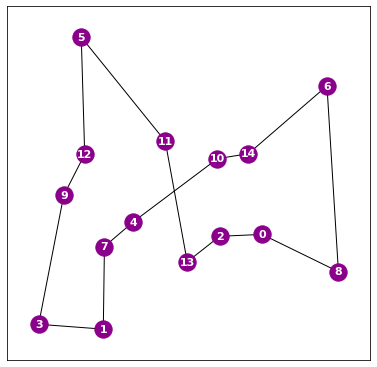

Generation: 889
Best distance: 26728.177


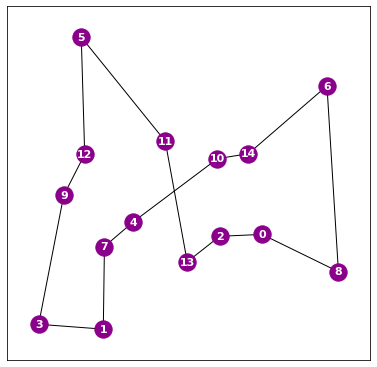

Generation: 2000
Best distance: 26728.177


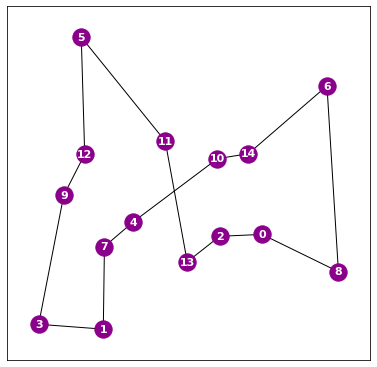

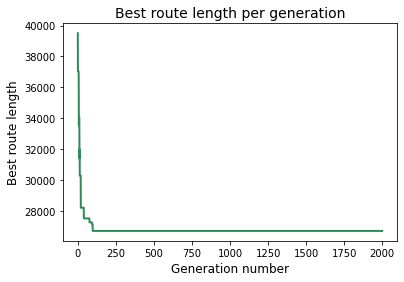

Best path in the final generation:
 ['4', '10', '14', '6', '8', '0', '2', '13', '11', '5', '12', '9', '3', '1', '7'] 
Distance: 26728.177


In [ ]:
# Import the modules we use in this notebook
import matplotlib.pyplot as plt
import random
import numpy as np
import networkx as nx

# This generates a map of the cities
def generate_uniform_map(xmin = -100, xmax = 100, 
                     ymin = -100, ymax =100, 
                     cities_count = 10, plot = False, seed = 2021):
    np.random.seed(seed)
    xs = np.random.uniform(xmin, xmax, cities_count)
    ys = np.random.uniform(ymin, ymax, cities_count)

    if plot:
        plt.scatter(xs, ys, s = 200, c = 'darkmagenta')
        plt.xlabel('X coordinate of the city')
        plt.ylabel('Y coordinate of the city')
        plt.show()

    # Pairs each x and y
    coords = np.dstack((xs, ys))[0]
    cities = dict()

    for i in range(len(coords)):
        cities[str(i)] = coords[i]

    return cities

# Initialize the population by generating random routes between the cities
def random_route(citylist):
    keys = list(citylist.keys())
    np.random.shuffle(keys)
    return keys

def initialize_routes(population_size, citylist):
    population = []
    for i in range(population_size):
        population.append(random_route(citylist))
    return population

# Get the length of the routes in our population so we can rank them from best to worst
def get_distance(citylist, indexi, indexj):
    city_a = citylist[indexi]
    city_b = citylist[indexj]
    x_dis = abs(city_a[0] - city_b[0])
    y_dis = abs(city_a[1] - city_b[1])
    distance = np.sqrt((x_dis ** 2) + (y_dis ** 2))
    return distance

def get_route_length(citylist, route):
    total_dist = 0
    for index in range(len(route)):
        if index < len(route) - 1:
            dist = get_distance(citylist, route[index], route[index+1])
        else:
            dist = get_distance(citylist, route[index], route[0])
        total_dist += dist
    return total_dist

def rank_routes(citylist, population):
    fitnessresults = []

    for index in range(len(population)):
        fitnessresults.append([index, get_route_length(citylist, population[index])])

    fitnessresults.sort(key=lambda x: x[1])
    return fitnessresults  

def get_crossover_pool(fitnessresults, population_size, survival_rate):
    cross_pool = []
    elite_amount = int(population_size * survival_rate)
    
    # We first place our direct survivors into the pool
    for route in fitnessresults[0:elite_amount]:
        cross_pool.append(route[0])

    return cross_pool

def davis_crossover(parent1, parent2):
    num_cities = len(parent1)
    child_1 = []
    child_2 = []
    breakpoints = np.sort(np.random.choice(num_cities,2,replace=False))
    for i in range(breakpoints[0],breakpoints[1]):
        child_1.append(parent1[i])
        child_2.append(parent2[i])
    sortpoint = num_cities - breakpoints[0]
    j = breakpoints[1]
    while len(child_1) < num_cities:
        while parent2[j%num_cities] in child_1:
            j += 1
        child_1.append(parent2[j%num_cities])
    child_1 = child_1[sortpoint:] + child_1[:sortpoint]
    j = breakpoints[1]
    while len(child_2) < num_cities:
        while parent1[j%num_cities] in child_2:
            j += 1
        child_2.append(parent1[j%num_cities])
    child_2 = child_2[sortpoint:] + child_2[:sortpoint]
    return [child_1, child_2]

# Obtain the children for the next generation by performing crossovers on the population
def population_crossover(population_size, population, cross_pool):
    children = []

    if len(cross_pool) % 2 != 0:
        cross_pool.pop()

    for routeindex in cross_pool:
        children.append(population[routeindex])

    while len(children) < population_size:
        sampleindex = np.random.choice(cross_pool, 2, replace = False)
        parent1 = population[sampleindex[0]]
        parent2 = population[sampleindex[1]] 
        children += davis_crossover(parent1, parent2)
    return children 

def mutate(route, mutation_rate, seed = 2021):
    for swapped in range(len(route)):
        if(np.random.random() < mutation_rate):
            swapwith = int(np.random.random() * len(route))
            route[swapped], route[swapwith] = route[swapwith], route[swapped]
            
    return route

def mutate_population(mutation_rate, children):
    mutated_routes = []

    for route in children:
        mutated_route = mutate(route, mutation_rate)
        mutated_routes.append(mutated_route)

    return mutated_routes

#######################################################################
###### These are just visualization functions. They don't affect ######
###### any of the code pertaining to the genetic algorithm ############
#######################################################################

def visualize(citylist, population, fitnessresults):
    # Creating a graph
    graph = nx.Graph()
    # Adding nodes to the graph
    graph.add_nodes_from(citylist.keys())
    # Getting the current best route
    if fitnessresults:
        best_route = fitnessresults[0][0]
        # Adding the edges that correspond to the current best route
        for node_index in range(len(population[best_route]) - 1):
            graph.add_edge(str(population[best_route][node_index]), str(population[best_route][node_index+1]))
        graph.add_edge(str(population[best_route][-1]), str(population[best_route][0]))
    # Creating layout
    pos = {}
    plt.figure(figsize=(6.5,6.5))
    for node in citylist.keys():
        pos[node] = tuple(citylist[node])
    nx.drawing.nx_pylab.draw_networkx(graph,pos=pos,font_color='white',\
        font_weight='bold',font_size=11,node_color='darkmagenta',node_size=300)
    plt.show()

# The function below chooses what generations to display
# The routes change quickly at first, and then more slowly as the evolution progresses.
# Thus, this function chooses to look at generations that are closer together 
# earlier in the evolution, becoming more spaced out as we go along. 
def get_displays(n_displays, n_plots, n_generations):
    displayed_gens = [1+np.floor((n_generations-1)*(i/n_displays)**2) for i in range(0, n_displays+1)]
    displayed_plots = [1+np.floor((n_generations-1)*(i/n_plots)**2) for i in range(0, n_plots+1)]
    return displayed_gens, displayed_plots

# Define the hyperparameters of our genetic algorithm
cities_count = 15
population_size = 50
n_generations = 2000
mutation_rate = 0.01
survival_rate = 0.5

# Initialize the population
cities =  {"0" :  (6734,1453),
"1": (2233,10),
 "2" : (5530,1424),
"3"  : (401,84),
 "4" : (3082,1644),
"5" : (1608,4458), "6" : (8573,3716),
"7" : (2265,1268) , "8" : (8898,885),
"9" : (1112,2049) , "10" : (5468,2606),
"11" : (3989,2873), "12" : (1706,2674),
"13" : (4612,1035) , "14": (6347,2683)
}


#generate_uniform_map(cities_count = cities_count, seed = 2021)
population = initialize_routes(population_size, cities)
fitnessresults = rank_routes(cities, population)

# Get generations to display
default_displays = 3
display = get_displays(default_displays,default_displays,n_generations)
fitness_evolution = np.zeros(n_generations)

# Main loop of the algorithm
for gen in range(1, n_generations+1):
    if gen in display[0]:
        print(f'Generation: {gen}\nBest distance: {str(round(fitnessresults[0][1],3))}')
    if gen in display[1]:
        visualize(cities, population, fitnessresults)
    cross_pool = get_crossover_pool(fitnessresults, population_size, survival_rate)
    if len(cross_pool)<2:
        print("Not enough parents to produce children!")
        print("For a population of size",population_size,", the survival rate must be at least",2/population_size)
        break
    else:
        children = population_crossover(population_size, population, cross_pool)
        population = mutate_population(mutation_rate, children)
        fitnessresults = rank_routes(cities, population)
        fitness_evolution[gen-1] = fitnessresults[0][1]

# plot to show fitness over the generations
if len(cross_pool)>=2:
    plt.plot(list(range(n_generations)),fitness_evolution,c = 'seagreen',linewidth=2)
    plt.title('Best route length per generation', fontsize = 14)
    plt.xlabel('Generation number', fontsize = 12)
    plt.ylabel('Best route length', fontsize = 12)
    plt.show()
    print("Best path in the final generation:\n",population[0],"\nDistance:",round(fitnessresults[0][1],3))
    
    
#Note: Fuctions used in the code are from class CS51 Session 13